In [11]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

from IPython.display import clear_output
import matplotlib.pyplot as plt

import segmentation_models as sm

import tensorflow_addons as tfa
import cv2
import numpy as np
import matplotlib
from matplotlib import pyplot
from matplotlib.image import imread

2.2.0


Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [8]:
def display(display_list, idx=None, only_inference=False, fig_size=15):
    """
    "only_inference" = True creates sample of inferenced image PNG file.
    """
    if only_inference:
        plt.figure(figsize=(fig_size,fig_size))
        #a = np.array(display_list)
        #a = a.astype(np.float32) * 255.0
        plt.imshow(display_list)
        plt.axis('off')
        plt.show()

        #cv2.imwrite("EX{}.png".format(idx), cv2.cvtColor(a, cv2.COLOR_RGB2BGR))
    
    else:
        plt.figure(figsize=(fig_size,fig_size))
        title = ['Input', 'True', 'Predcited']

        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
            plt.axis('off')

        plt.show()
    

In [9]:
def create_mask(pred_mask, num=0):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[num]

def show_predictions(test_mode=False, x=None,y=None, num=1):
  if test_mode:
    print("In testing Mode...")
    for i in range(num):
      pred_mask = model.predict(x, batch_size=1)
      display([x[i], y[i], create_mask(pred_mask, num=i)])

  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [50]:
def onehot_to_rgb(one_hot):

    channel_0 = np.zeros((480,576,1)) #prediction
    channel_1 = np.zeros((480,576,1))
    channel_2 = np.zeros((480,576,1))
    
    ex = one_hot # ex = H,W,1

    #pushed = tf.expand_dims(ex[:,:,1], -1) + tf.expand_dims(ex[:,:,2], -1)
    #circle = tf.expand_dims(ex[:,:,3], -1)
    #stamped = tf.expand_dims(ex[:,:,2], -1) # stamped = H,W,1
    #bg = tf.expand_dims(ex[:,:,0], -1)
    #hole = tf.expand_dims(ex[:,:,4], -1)

    channel_0[ex==1] = color_dict[1][0]
    channel_1[ex==1] = color_dict[1][1]
    channel_2[ex==1] = color_dict[1][2]

    channel_0[ex==3] = color_dict[3][0]
    channel_1[ex==3] = color_dict[3][1]
    channel_2[ex==3] = color_dict[3][2]

    channel_0[ex==2] = color_dict[2][0]
    channel_1[ex==2] = color_dict[2][1]
    channel_2[ex==2] = color_dict[2][2]

    channel_0[ex==0] = color_dict[0][0]
    channel_1[ex==0] = color_dict[0][1]
    channel_2[ex==0] = color_dict[0][2]
    

    com = tf.concat([channel_0, channel_1, channel_2], -1)

    display(com, only_inference=True,fig_size=10)

In [41]:
#Compile Options
ACTIVATION = "softmax"
FROM_LOGITS = False 
OPTIMIZER = "RMSprop" 
LR = 0.00005 #0.0001
ENC_FREEZE = False
BACKBONE = 'inceptionv3'

#Fit options
EPOCHS = 100
BATCH = None
NUM_VAL = 10
F_EPOCHS = 20

#Other
IMG_SIZE = (480,576) #Image size must be multiples of 48 to support segmentation models (PSPNET)
STEPS_PER_EPOCH = 30

IMG_SIZE_down = (192, 480) # original 227 490
IMG_SIZE_up_bid = (240, 528) # original 240 534
IMG_SIZE_up_body = (960, 528) # original 991, 534

Get One sample & get unique colors

(227, 490, 3)
(240, 534, 3)
(991, 534, 3)


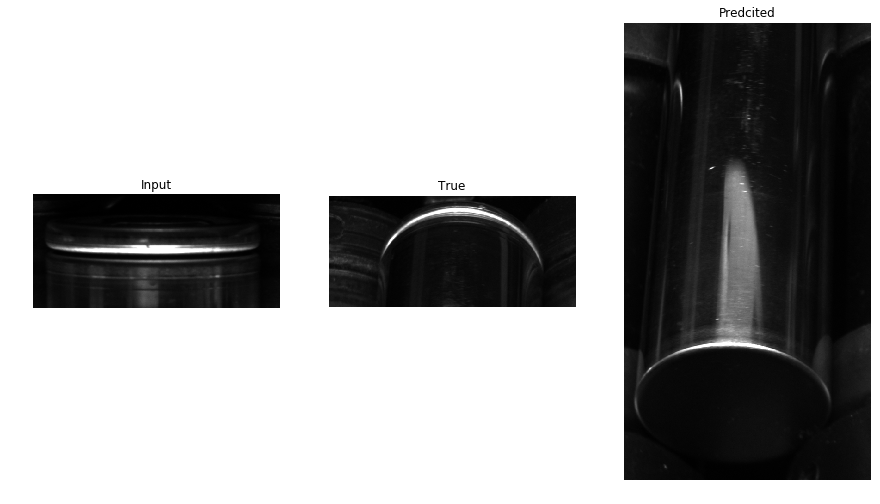

In [17]:
down = cv2.imread('bidding_images/down/downcon1/2021-07-18_19-39-46_10.bmp_0.bmp') # 227 * 490
up = cv2.imread('bidding_images/up/upmid1/bidding/2021-07-18_20-16-27_10.bmp_0.bmp') # 240 * 534
up_body = cv2.imread('bidding_images/up/upmid1/body/2021-07-18_20-16-27_10.bmp_0.bmp') # 991 * 534 

print(mask.shape)
print(up.shape)
print(up_body.shape)
display([mask,up,up_body])

In [73]:
color_dict = {i: list(x) for i,x in enumerate(colors)}

print(color_dict)

def rgb_to_onehot(rgb_arr, color_dict):
    num_classes = len(color_dict)
    shape = rgb_arr.shape[:2] + (num_classes,)
    arr = np.zeros(shape, dtype=np.int32)
    for i, cls in enumerate(color_dict):
        arr[:, :, i] = np.all(rgb_arr.reshape((-1, 3)) == color_dict[i], axis=1).reshape(shape[:2])
    return arr

{0: [0.0, 0.0, 0.0], 1: [0.9607843, 0.5764706, 0.19215687], 2: [0.98039216, 0.19607843, 0.3254902], 3: [0.98039216, 0.98039216, 0.21568628], 4: array([0., 0., 1.])}


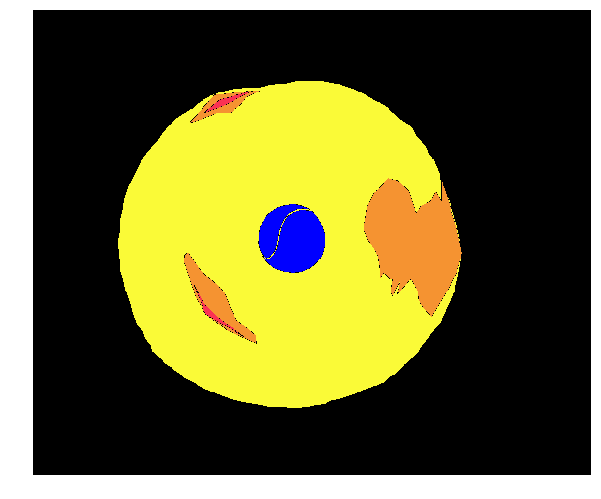

In [74]:
a = rgb_to_onehot(mask,color_dict)


bb = tf.expand_dims(np.argmax(a, axis=-1),-1)
bbb = tf.image.resize(bb, IMG_SIZE) #480, 576 960,1152

#ccc = tf.image.flip_left_right(bbb)
angle = np.random.uniform(0,2*np.pi)
ccc = tfa.image.rotate(bbb, angle)

#display([bbb, ccc])

onehot_to_rgb(bbb)

Preprocess train images/masks:
  1. resize both
  2. for x, convert to rgb
  3. for mask, convert to one hot?
  4. for both, apply augmentation (optional)

  Note: mask in png format, img in bmp format


In [32]:
from glob import glob
import cv2
train_x = []
train_y = []

img_loc = 'bidding_images/down/*/*.bmp'
img_loc2 = 'bidding_images/down/*/*/*.bmp'

for img in (glob(img_loc) + glob(img_loc2)):
    #Image
    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE_down) #480, 576
    
    train_x.append(n)

    #MASK
    y = tf.zeros(list(IMG_SIZE_down)+[1])

    train_y.append(y)

train_x = tf.convert_to_tensor(train_x)
train_y = tf.convert_to_tensor(train_y)

print(train_x.shape, np.max(train_x))
print(train_y.shape, np.max(train_y))

(858, 192, 480, 3) 0.99607843
(858, 192, 480, 1) 0.0


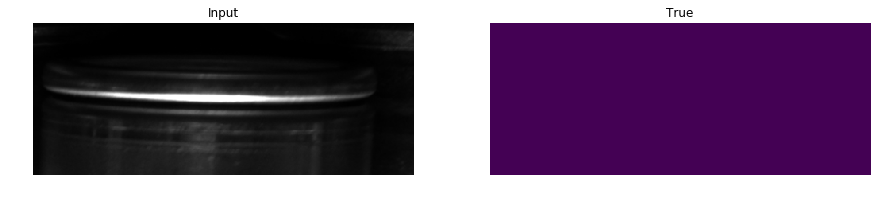

NameError: name 'onehot_to_rgb' is not defined

In [33]:
display([train_x[13], train_y[13]])
#onehot_to_rgb(train_y[13])

In [34]:
sample_image = train_x[13]
sample_mask = train_y[13] 

찍힘 class에 가장 높은 weight, "눌림" class에 그 다음 높은 weight 적용

In [79]:
# 0 shows background, 1 shows "pushed", 2shows "Stamped", 3shows inner circle
sample_weights = np.zeros(train_y.shape)

bg_count = (np.array(train_y)==0).sum()
circle_count = (np.array(train_y)==3).sum()
push_count = (np.array(train_y)==1).sum()
stamp_count = (np.array(train_y)==2).sum()


denom = bg_count+circle_count+push_count+stamp_count

CLASS_WEIGHT = [(denom/bg_count).round(), (denom/push_count).round(), (denom/stamp_count).round(), 
                (denom/circle_count).round()]

print(CLASS_WEIGHT)

# your own weight corresponding here:
sample_weights[train_y==0] = CLASS_WEIGHT[0]                                                                                                             
sample_weights[train_y==1] = CLASS_WEIGHT[1]                                                                                                            
sample_weights[train_y==2] = CLASS_WEIGHT[2]                                                                                                             
sample_weights[train_y==3] = CLASS_WEIGHT[3]      

[2.0, 86.0, 3063.0, 3.0, 77.0]


In [29]:
print(sample_weights.shape)
print(train_x.shape, train_y.shape)

(184, 480, 576, 1)
(184, 480, 576, 3) (184, 480, 576, 1)


Define Backbone model as well as segmentation model

In [36]:
sm.set_framework('tf.keras')
sm.framework()

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR) #default 0.001


model = sm.PSPNet(BACKBONE, input_shape = IMG_SIZE_down + (3,), classes=3, encoder_weights='imagenet', 
                  activation=ACTIVATION, encoder_freeze = ENC_FREEZE)

model.compile(
    optimizer = opt,
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'], 
)

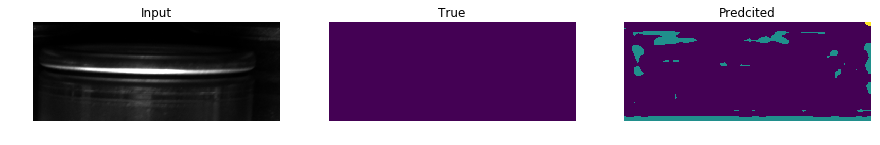

In [37]:
show_predictions()

In [38]:
import gc
import os
import datetime

gc.collect()

class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('{}에포크 이후의 예측 예시'.format(epoch+1))
    print ('Current Accuracy: {}'.format(logs['accuracy']))
    print ('Validation Accuracy: {}'.format(logs['val_accuracy']))
    gc.collect()
    

Setting validatoin_split causing not to train well for some reason

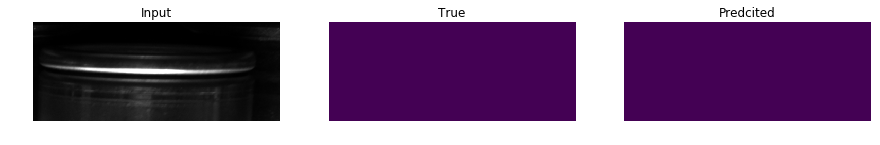

6에포크 이후의 예측 예시
Current Accuracy: 1.0
Validation Accuracy: 1.0
30/30 [==============================] - 6s 209ms/step - loss: 3.2214e-05 - accuracy: 1.0000 - val_loss: 0.0032 - val_accuracy: 1.0000
Epoch 7/100
10/30 [=========>....................] - ETA: 3s - loss: 1.1163e-05 - accuracy: 1.0000

KeyboardInterrupt: 

In [40]:
model_history = model.fit(x= train_x[NUM_VAL:],
                          y= train_y[NUM_VAL:], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=EPOCHS,
                          validation_data = (train_x[:NUM_VAL], train_y[:NUM_VAL]),# sample_weights[:NUM_VAL]),
                          callbacks=[DisplayCallback()],)
                          #sample_weight=sample_weights[NUM_VAL:])                                

In [84]:
test_x = []
test_y = []

for img in glob.glob("JR_dataset/test/*.bmp"):

    n = cv2.imread(img)
    n = tf.cast(n, tf.float32) / 255.0
    n = tf.image.resize(n, IMG_SIZE)
    
    test_x.append(n)
    
    dir = "/".join(img.split("/")[:-1]) + "/new_gt_mask/"
    file_name = img.split("/")[-1].split('.')[0]

    #MASK
    y = imread(dir+file_name+".png")
    a = rgb_to_onehot(y, color_dict) #change to one hot

    bb = tf.expand_dims(np.argmax(a, axis=-1),-1) #combine one hot
    bbb = tf.image.resize(bb, IMG_SIZE)
    
    test_y.append(bbb)

test_x = tf.convert_to_tensor(test_x)
test_y = tf.convert_to_tensor(test_y)

print(test_x.shape)
print(test_y.shape)

(4, 480, 576, 3)
(4, 480, 576, 1)


In testing Mode...


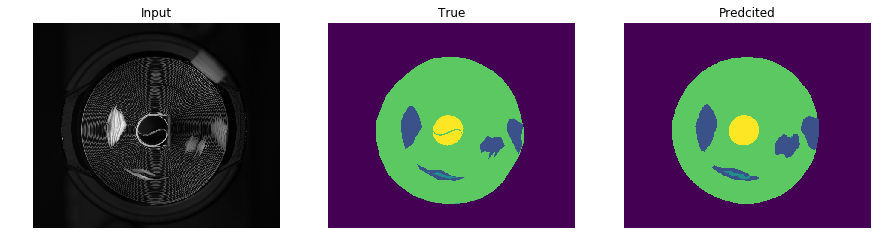

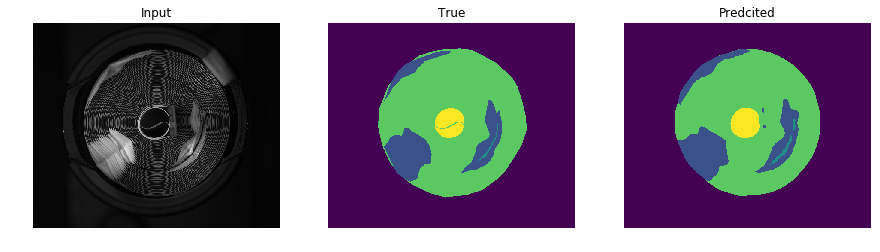

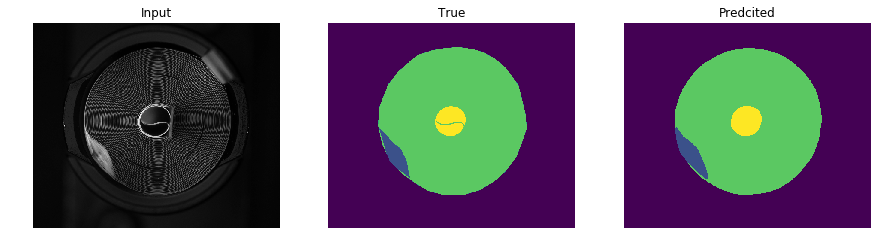

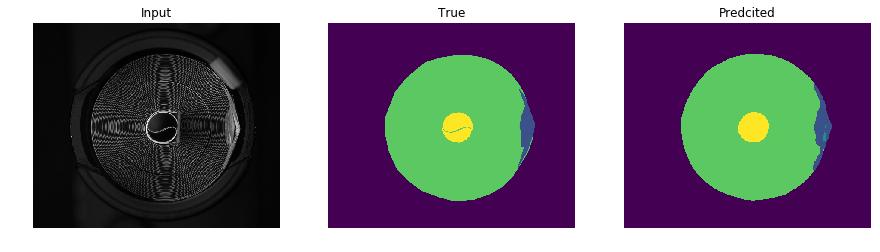

In [85]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

Finetuning with smaller learning rate (make whole model trainable)



In [38]:
model.trainable = True

if OPTIMIZER == "Adam":
    opt = keras.optimizers.Adam(learning_rate=LR/10) #default 0.001
elif OPTIMIZER == "RMSprop":
    opt = keras.optimizers.RMSprop(lr=LR/10) #default 0.001

model.compile(
    optimizer = opt,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=FROM_LOGITS), 
    metrics=['accuracy'],
)

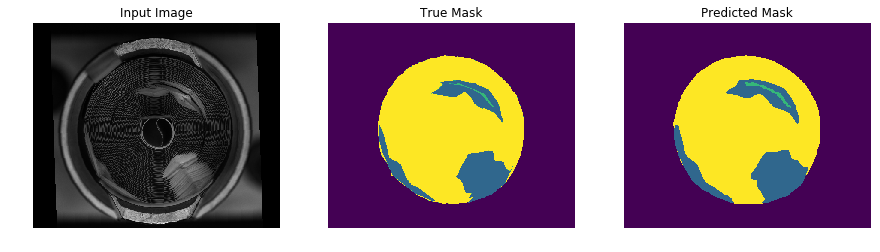

20에포크 이후의 예측 예시
Current Accuracy: 0.9929144978523254
Validation Accuracy: 0.9836881756782532
10/30 [=========>....................] - 2s 185ms/step - loss: 0.1000 - accuracy: 0.9929 - val_loss: 6.3991 - val_accuracy: 0.9837


In [39]:
finetune_history = model.fit(x= train_x[NUM_VAL:],
                          y= train_y[NUM_VAL:], 
                          batch_size = BATCH,
                          steps_per_epoch = STEPS_PER_EPOCH,
                          epochs=F_EPOCHS,
                          validation_data = (train_x[:NUM_VAL], train_y[:NUM_VAL], sample_weights[:NUM_VAL]),
                          callbacks=[DisplayCallback()],
                          sample_weight=sample_weights[NUM_VAL:])    

In [ ]:
"""
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))
"""

"\n%tensorflow_version 2.x\nimport tensorflow as tf\ndevice_name = tf.test.gpu_device_name()\nif device_name != '/device:GPU:0':\n  raise SystemError('GPU device not found')\nprint('Found GPU at: {}'.format(device_name))\n"

WITH FINETUNING

In testing Mode...


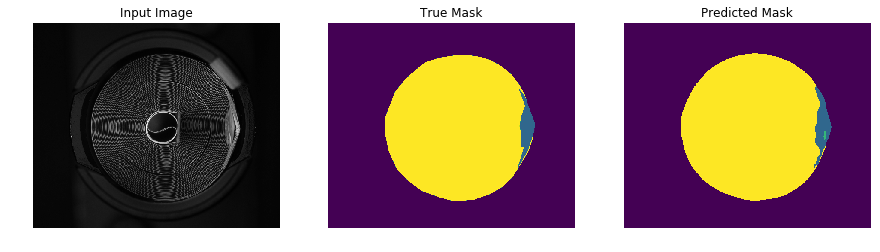

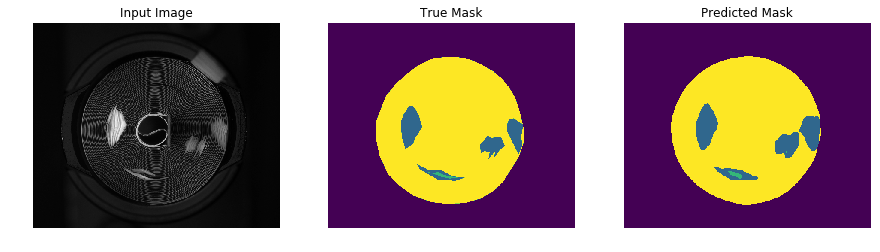

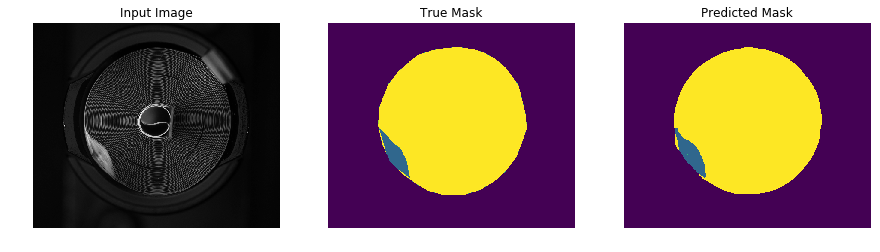

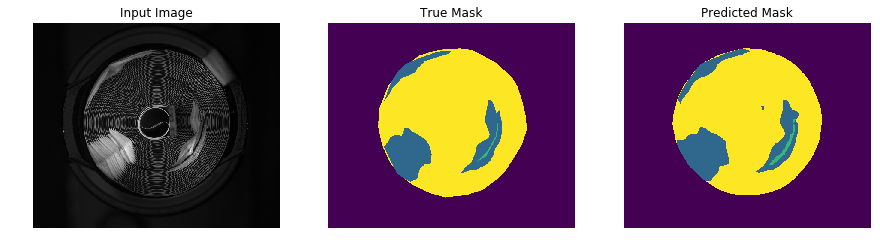

In [40]:
show_predictions(test_mode=True, x=test_x, y=test_y, num=4)

In [41]:
pred_mask = model.predict(test_x, batch_size=1)
aaa = create_mask(pred_mask, num=3)
dd = tf.one_hot(aaa, 4)
print(dd.shape)

(480, 576, 1, 4)


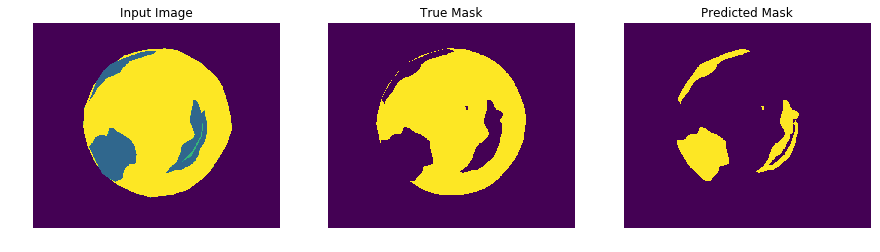

In [42]:
display([test_y[3], dd[:,:,:,3], dd[:,:,:,1]]) 
# 0 shows background, 1 shows "pushed", 2shows "Stamped", 3shows inner circle

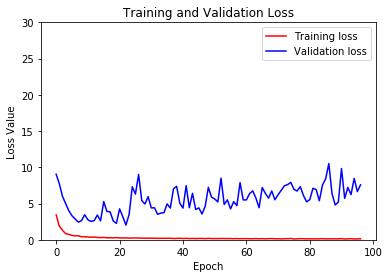

In [43]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS-3)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 30])
plt.legend()
plt.show()

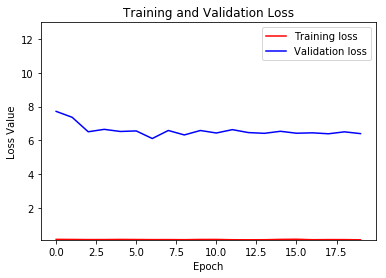

In [44]:
loss = finetune_history.history['loss']
val_loss = finetune_history.history['val_loss']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0.1, 13])
plt.legend()
plt.show()

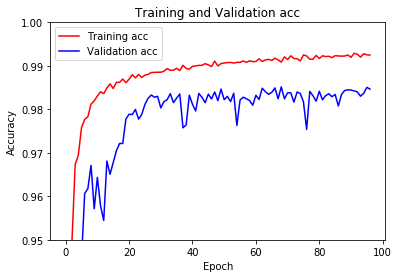

In [45]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']

epochs = range(EPOCHS-3)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.95,1])
plt.legend()
plt.show()

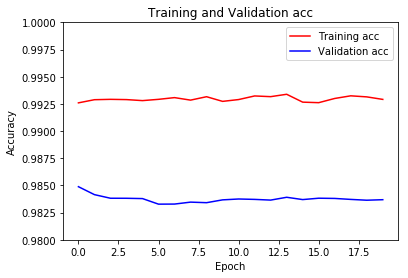

In [46]:
acc = finetune_history.history['accuracy']
val_acc = finetune_history.history['val_accuracy']

epochs = range(F_EPOCHS)

plt.figure()
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.98,1])
plt.legend()
plt.show()

In [47]:
print("Training accuracy at the last epoch is:", np.round(model_history.history['accuracy'][-1],3))

Training accuracy at the last epoch is: 0.992


In [48]:
print("Training accuracy (after finetuning) at the last epoch is:", np.round(finetune_history.history['accuracy'][-1],3))

Training accuracy (after finetuning) at the last epoch is: 0.993


Saving Model for use in Inference

In [49]:
model.save('saved_model_1006_{}_{}_{}_B{}_classweights_P{}_S{}_EncoderTrained'.format(OPTIMIZER, EPOCHS, LR, BATCH, 
                                                                       np.int(CLASS_WEIGHT[1]), np.int(CLASS_WEIGHT[2])))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: saved_model_1006_RMSprop_100_5e-05_BNone_classweights_P86_S3060_EncoderTrained/assets
